# Comportement des électeurs de l'article 9


In [2]:
#coding: utf-8

#import des modules
#lecture des json
import json 
#affichage des dictionnaires avec idententation
import pprint
pp = pprint.PrettyPrinter(indent=4, )
#librairie des graphes
import networkx as nx
#affichage des graphs
import matplotlib
import matplotlib.pyplot as plt
#calcul
import numpy as np
from itertools import combinations
%matplotlib inline

##    La version originale de l'article 9

In [3]:
def load_vo(art_file = "./article_9.json"):
    with open(art_file, "r") as f:
        article9 = json.load(f)
    return article9
article_9 = load_vo()

In [4]:
#votes dans l'article 9

print(article_9["votes_total"], "votes")
print(len(article_9["arguments"]), "arguments")
print(len(article_9["sources"]), "sources")



3334 votes
132 arguments
22 sources


## Toutes les  versions de l'article 9

Nous allons charger les informations contenues dans le fichier article 9:
* la version originale (qui correspond aux statistiques finales de votes sur l'article)
* les versions complémentaires (soit les 108 modifications additionnelles proposées au vote)
selon la même nomenclature (les versions complémentaires de l'article 9 sont identifiées par le slug de l'article)
elles contiennent un ensemble de votes la modification apportée et un ensemble d'arguments 

#### Une petite explication sur la génération des slugs
Ils servent de clés au dictionnaire de versions:
Notre but étant de rappatrier les votes de chaque versions  pour chaque participant
il faut identifier de quelle version il s'agit.
Ici pour faciliter le travail et comme on peut voir plus haut
la version originale correspond au nom de générique de l'article

Recapitulons:

L'url de la version originale se présente sous cette forme:
```
urlV_0 = "http://www.republique-numerique.fr/projects/projet-de-loi-numerique/consultation/consultation/opinions/section-2-travaux-de-recherche-et-de-statistique/article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"
```
L'url des versions se présentent toujours sous cette formes
```
urlV_add = "http://www.republique-numerique.fr/projects/projet-de-loi-numerique/consultation/consultation/opinions/section-2-travaux-de-recherche-et-de-statistique/article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics/versions/mise-a-disposition-systematique-des-resultats-de-la-recherche-financee-par-des-fonds-publics"
```

Le slug (raccourci) est produit de la manière suivante:
* on découpe les urls en morceaux a partir de "/" et on prend le dernier element de la liste de la manière suivante
```
liste_element_url = url.split("/")
slug = liste_element_url[-1]
```
    * vérifions pour la version originale:
```
liste_element_url = urlV_O.split("/")
print(liste_element _url)
slug = liste_element_url[-1]
print(slug)
```
On est censé avoir:
```
>>> ['http:', '', 'www.republique-numerique.fr', 'projects', 'projet-de-loi-numerique', 'consultation', 'consultation', 'opinions', 'section-2-travaux-de-recherche-et-de-statistique', 'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics']
>>>'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics'
```
    * vérifions pour une autre version:
```
liste_element_url = urlV_add.split("/")
print(liste_element _url)
slug = liste_element_url[-1]
print(slug)
```
On est censé avoir:
```
>>> ['http:', '', 'www.republique-numerique.fr', 'projects', 'projet-de-loi-numerique', 'consultation', 'consultation', 'opinions', 'section-2-travaux-de-recherche-et-de-statistique', 'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics', 'versions', 'mise-a-disposition-systematique-des-resultats-de-la-recherche-financee-par-des-fonds-publics']
>>>'mise-a-disposition-systematique-des-resultats-de-la-recherche-financee-par-des-fonds-publics'
```

In [5]:
def load_versions(art_file="article9.json"):
    '''charger l'ensemble des versions de l'article'''
    versions_d = {}
    with open(art_file, "r") as f:
        article9 = json.load(f)
    
    #Pour rappel
    #print article9.keys()
    versions_d[article9["article_link"].split("/")[-1]] = {
                "id": 0,
                "date": article9["created_at"],
                "link": article9["article_link"],
                "slug": article9["article_link"].split("/")[-1],
                "title": article9["article_link"].split("/")[-1].replace("-", " "),
                "text": article9['body'],
                "author": article9["author"],
                "votes":[],                                               #<= rappatriés par la suite
                "arguments":article9["arguments"], #<= les arguments de l'article
                "votes_arguments": [],                                    #<= rappatriés par la suite
                "sources":article9["sources"],#<= les sources de l'article
                "votes_sources": [],                                      #<= rappatriés par la suite
                "total_votes": article9["votes_total"],#<= les votes comptabilisés
                #les décomptes de votes sur les arguments ne sont pas disponible dans l'article9
                  # seulement le nombre d'arguments
                "total_arguments_votes": article9["arguments_count"]
               }
    #les versions de l'article sont stockés dans le fichier à "versions"
    versions = article9["versions"]
    
    #on construit une liste de versions
    for i,v in enumerate(versions):
        #pour rappel
        #print v.keys()
        versions_d[v["slug"]] = {"date":v["created_at"],
                "id": i+1,
                "link":v["link"],
                #"slug":v["slug"],
                "title":v["title"],
                "text": v['comment'],
                "author": v["author"],
                "votes":[], 
                "arguments":[], 
                "votes_arguments": [],
                "sources":[],
                "votes_sources": [],
                "total_votes":v["votes_total"],
              #ici il s'agit bien du nombre de votes sur un argument
                "total_arguments_votes": v["arguments_count"]
             }
    print(len(versions_d), "versions de l'article 9")
    return versions_d

In [6]:
#les versions
versions = load_versions("./article_9.json")

109 versions de l'article 9


On a donc maintenant un référentiel de versions successives pour l'article9

# Les participants

Nous allons maintenant récupérer l'ensemble de la liste des participants au *projet de loi*
avec leurs votes respectifs qui sont dans le fichier participants.json
Pour cela, nous allons construire un dictionnaire participants_d
{username: [vote1, vote2, vote3,...]}


In [7]:
def load_participants():
    #charger les votes des participants
    with open("./participants.json", "r") as f:
        data = json.load(f)
        participants = data["participants"]
    
    participants_d = {}
    for part in participants:
        for k,v in part.items():
            
            participants_d[k] = v["votes"]
        
    print (len(participants_d), "participants sur l'ensemble des articles")
    return participants_d

In [8]:
# les participants
participants = load_participants()

21329 participants sur l'ensemble des articles


### Les electeurs de l'article 9

Nous allons dans `update_version`
mettre à jour notre référentiel de version en ajoutant les votes de chaque participants
Rappelez vous dans notre dictionnaire de versions pour l'article9, les votes, votes_arguments, votes_sources sont des listes encore vides

Le détail des votes est disponible dans participants et sont organisés par electeurs
Nous allons donc regarder pour chaque electeur et pour chaque vote:
    - s'il a voté pour une des versions de l'article 9
    identifiable par son nom générique 
```
art = "article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"
``` 
    - vérifier pour quelle version il a voté:
    identifiable par le slug (cf. plus haut)
    - vérifier ensuite s'il s'agit d'un vote sur une source argument ou la version elle même
    identifiable par #source-<id> ou #arg-<id> ou s'il n'en a pas il s'agit de la version elle même
    

In [9]:
def update_versions(participants, versions_d, art="article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"):
    #pour chaque participant
    for user, votes in participants.items():
        #pour chaque vote du participants
        for vote in votes:            
            link = vote["link"]
            #a-t-il voté pour notre article?
            if art in link:
                
                date =  vote["date"]
                opinion = vote["opinion"]
                #pour quelle version?
                slug = link.split("/")[-1]
                
                #est ce qu'on peut découper avec #?
                # = y a t'il une info complémentaire du type #arg #source
                try:
                    #oui: c'est un vote sur un arg ou une source
                    slug_, tid = slug.split("#") 
                    
                    #exemple:
                    
                    if tid.startswith("arg-"):
                        #print(tid)
                        #dans notre dictionnaire de référence sur les versions
                        #c'est un argument on stocke dans les votes pour les arguments
                        versions_d[slug_]["votes_arguments"].append({"electeur":user,"vote": opinion, "date":date, "id":tid})
                    elif tid.startswith("source-"):
                        #c'est une sources on stocke dans les votes pour les sources
                        versions_d[slug_]["votes_sources"].append({"electeur":user,"vote": opinion, "date":date, "id":tid})
                    else:
                        #au cas ou il y aurait un #autrechose mais ne s'applique pas ici
                        print(slug_)
                except:
                                         #non: c'est donc un vote simple sur une version (originale ou autre)
                    versions_d[slug]["votes"].append({"electeur":user,"vote": opinion, "date":date})
    
    return versions_d
    

In [10]:
#mise à jour des versions en intégrants les votes des participants
full_versions = update_versions(participants, versions)


Notre référentiel de versions est mis à jour et contient désormais 
le détail des votes pour chaque version.

Petit rappel de repartition des votes par types:
    * votes sur les versions "votes":[]
    * votes sur les arguments de chaque versions "votes_arguments":[]
    * votes sur les sources de chaque versions "votes_sources"

Les votes sont rangés par version dans des listes. Chaque vote est ensuite caractérisé par une date, l'electeur, le vote et son id unique dans un dictionnaire. {"date":XXXX, "electeur": "username", "id": XXX, "vote":(1|0|-1)}

Nous allons commencer par faire quelques verifications du nombre de votes total toutes versions confondues.

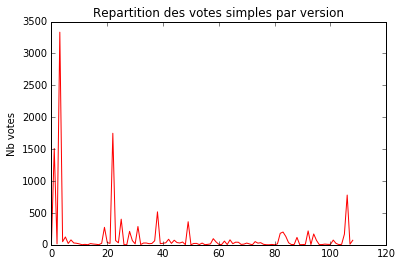

In [11]:
### Vérifions donc la repartition des votes simple par version

def show_nb_votes_by_versions(vs):
    #for k,v in vs.items():
    #    print(len(v["votes"]),"votes sur la version:" , k )
    N = len(vs)
    votes_nb = [len(v["votes"])  for v in vs.values()]
    
    plt.title("Repartition des votes simples par version")
    plt.ylabel('Nb votes')
    #pylab.xlim([0,108])
    #pylab.xlim([0,N])
    plt.plot(votes_nb,color='r')
    #votes_declares = [v["total_votes"] for v in vs.values()]
        
    #votes_declares = [len(v["total_votes"]) for v in vs.values()]
    #plt.plot(votes_declares,color='b')
    plt.show()
    
    return
show_nb_votes_by_versions(versions)

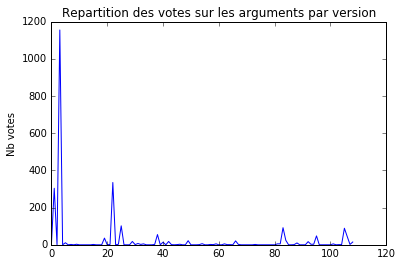

In [12]:
#verifions maintenant les votes par arguments
def show_nb_votes_args_by_versions(vs):
    #for k,v in vs.items():
    #    print(len(v["votes"]),"votes sur la version:" , k )
    N = len(vs)
    votes_nb = [len(v["votes_arguments"])  for v in vs.values()]
    
    plt.title("Repartition des votes sur les arguments par version")
    plt.ylabel('Nb votes')
    #pylab.xlim([0,108])
    #pylab.xlim([0,N])
    plt.plot(votes_nb,color='b')

    plt.show()
    
    return
show_nb_votes_args_by_versions(versions)

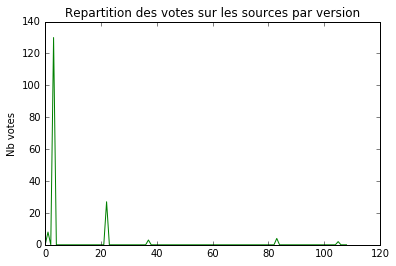

In [13]:
#verifions maintenant les votes sur les sources pour chaque version
def show_nb_votes_args_by_sources(vs):
    #for k,v in vs.items():
    #    print(len(v["votes"]),"votes sur la version:" , k )
    N = len(vs)
    votes_nb = [len(v["votes_sources"])  for v in vs.values()]
    
    plt.title("Repartition des votes sur les sources par version")
    plt.ylabel('Nb votes')
    #pylab.xlim([0,108])
    #pylab.xlim([0,N])
    plt.plot(votes_nb,color='g')

    plt.show()
    
    return
show_nb_votes_args_by_sources(versions)

On voit donc une modification particulière a cristallisé les réactions des électeurs entrainant un vote massif
aussi bien sur les arguments, les sources utilisées que les opinions simples (pour, contre, neutre) il s'agit enr éalité de l'article dans sa version originale

Elles correspondent aussi au moment fort de la consultation. 
Voyons donc le nombre de votes total


In [14]:
votes_simples = [len(v["votes"]) for k, v in versions.items()]
print(max(votes_simples), "votes maximum")
print(sum(votes_simples), "votes total")
votes_args = [len(v["votes_arguments"]) for k, v in versions.items()]
print(max(votes_args), "votes args maximum")
print(sum(votes_args), "votes args total")

votes_sources = [len(v["votes_sources"]) for k, v in versions.items()]
print(max(votes_sources), "votes sources maximum")
print(sum(votes_sources), "votes sources total")

print(sum(votes_simples)+sum(votes_args)+sum(votes_sources), "votes au total")
print ("===========")
print("Les votes comptabilisés:")
print(article_9["votes_total"], "votes")


3334 votes maximum
12851 votes total
1155 votes args maximum
2522 votes args total
130 votes sources maximum
174 votes sources total
15547 votes au total
Les votes comptabilisés:
3334 votes


On note donc une différence entre les votes compatibilisés de la version originale et les votes réels émis.
On découvre en passant donc que les votes comptabilisés par le gouvernement ne prend en compte que le nombre de **votes de la versions originale**. 

La proposition d'amender un article et de voter pour cette version de texte n'a eu une aucune incidence sur le choix de réécriture des articles ni sur le droit de réponse ouvert par le gouvernement sur la base des articles les plus votés.
Les systèmes de votes multiples (article, amendements, arguments) n'est donc pas intégré au processus de validation de consultation final dans un souci de s'assurer sans doute qu'un électeur n'a voté qu'une seule fois.

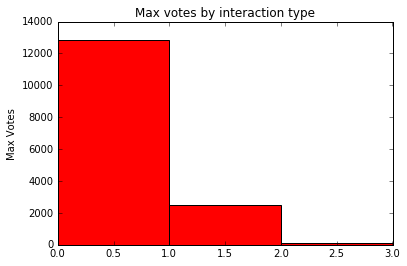

In [15]:


fig = plt.figure()
x = [0, 1, 2]
y = [sum(votes_simples), sum(votes_args), max(votes_sources)]
fig, ax = plt.subplots()
rects1 = ax.bar(x, y, 1, color='r')
# add some text for labels, title and axes ticks
ax.set_ylabel('Max Votes')
ax.set_title('Max votes by interaction type')
plt.show()


## Concentrons nous sur les electeurs de l'article 9

Maintenant que nous avons nos votes par versions 
nous allons charger le **détail** des votes pour l\'article9 qui nous intéresse ici soit:
* l'électeur 
* la version 
* le vote
* la date
 aussi bien sur l'original que sur les modifications proposées

In [16]:
def load_votes(participants,art ="article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"):
    #charger les votes des electeurs de l'article 9
    votes_v = []
    votes_args = []
    votes_src = []
    for user, votes in participants.items():
        for vote in votes:
            link = vote["link"]
            if art in link:
                date =  vote["date"]
                opinion = vote["opinion"]
                slug = link.split("/")[-1]
                try:
                    slug, tid = slug.split("#") 
                    if "arg-" in tid:
                        votes_args.append({"electeur":user,"vote": opinion, "slug":slug, "date":date, "id":tid})
                    elif "source-" in tid:
                        votes_src.append({"electeur":user,"vote": opinion, "slug":slug, "date":date, "id":tid})
                    else:
                        pass
                        #votes_v.append({"electeur":user,"vote": opinion, "slug":slug, "date":date})
                except:
                    #s'il n'a pas d"identifiant il s'agit d'un vote simple
                    votes_v.append({"electeur":user,"vote": opinion, "slug":slug, "date":date})
            
    print(len(votes_v),"votes", len(votes_args),"votes sur les arg", len(votes_src), "votes sur les sources")
    return votes_v, votes_args, votes_src
    

In [17]:
votes9, votes_args9, votes_sources9 = load_votes(participants)

12851 votes 2522 votes sur les arg 174 votes sur les sources


# Filtrer les electeurs les plus actifs

* Premier objectif : calculer combien de fois un electeur a voté au total (c'est à dire sur toutes les versions de l'article) on se concentre uniquement sur les votes simples


In [18]:
def count_votes_electeurs(votes):
    #ici on compte simplement le nombre de nom d'electeur dans  la liste de votes 
    #soit pour chaque electeur son nombre de vote total peut importe la version
    from collections import Counter, defaultdict
    electeur_nb_votes = dict(Counter([data["electeur"] for data in votes]))
    return electeur_nb_votes
    
electeur_nb_votes  = count_votes_electeurs(votes9)

def how_many_votes_for(username):
    electeur_nb_votes  = count_votes_electeurs(votes9)
    nb_votes = electeur_nb_votes[username] 
    print (username, "voted", nb_votes, "times" )
    return nb_votes
def weight_of_contribution(username):
    '''in pourcentage'''
    electeur_nb_votes  = count_votes_electeurs(votes9)
    pourcent = (electeur_nb_votes[username]/len(votes9))*100
    print (username, "contributes at", pourcent, "% of total votes" )
    return pourcent
    

how_many_votes_for("syndicatnationaldeledition")
weight_of_contribution("syndicatnationaldeledition")



syndicatnationaldeledition voted 44 times
syndicatnationaldeledition contributes at 0.34238580655201933 % of total votes


0.34238580655201933

* Deuxième objectif: qui sont les électeurs les plus actifs?

In [19]:


import operator
nb_votes = sorted(electeur_nb_votes.items(), key=operator.itemgetter(1))[::-1]

#les 5 electeurs les plus actifs avec leur nombre de votes
print(nb_votes[:5])


[('jeannevarasco', 88), ('vincentreverdy', 80), ('duflotjeanluc', 55), ('syndicatnationaldeledition', 44), ('charlesruelle', 43)]


* Troisième objectif: evaluer le seuil critique de participations a partir de la fréquence de votes

A partir de quel moment la participation d'un électeur compte?

Les participants pouvaient voter plusieurs fois, 
on peut analyser le poid de l'ensemble des participants 
dans le vote pour mieux évaluer les relations.

Soit x nb d'electeurs on contribué à x % des votes.


Si on analyse la répartition des electeurs / X le nombre de votes, on se rend compte comme la plupart des datasets que 80% des electeurs ont compté pour moins de 20 % des votes

## Fréquence de votes

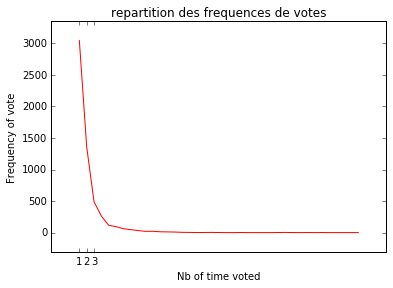

In [20]:
from collections import Counter, defaultdict
repartition = dict(Counter(elem[1] for elem in nb_votes))
#for nb_vote, total in repartition.items():
#    print ("%i electeurs ont votés %i fois"%(total,nb_vote))
#    print ("soit %i votes qui représentent %i pourcent des votes" %(nb_vote*total,nb_vote*total/len(votes9)*100))

fig = plt.figure()
total_votes = [k*v for k,v in repartition.items()]

#plt.plot(list(repartition.values()),color='g')
plt.plot(list(repartition.values()), 'r')
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, list(repartition.keys()))
#plt.plot(total_votes, "g")
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.1)
#fig.set_xlabel('Nb d electeur')
#fig.set_ylabel('nb de votes')
plt.xlabel('Nb of time voted')
plt.ylabel('Frequency of vote')
plt.title('repartition des frequences de votes')
#plt.show()
plt.show()
    




## Top électeurs

Si on veut analyser le comportement des électeurs, 
il s'agit de se concentrer sur les électeurs les plus engagés et actifs.

On va donc établir un filtre d'activité. 

Ici on va filtrer les electeurs les plus actifs selon un nb_votes_min
qui veut dire l'electeur doit avoir voté au moins X fois
On récupère la liste des votes correspondants.


In [21]:
def filter_top_electeurs(nb_votes, votes9, nb_votes_min):
    top_electeurs = []
    sum_votes = []
    for electeur, nb in nb_votes:
        if nb >= nb_votes_min:
            top_electeurs.append(electeur)
            sum_votes.append(nb)
    #from collections import Counter, defaultdict
    #on recupère le nom des electeurs
    #qui ont voté au moins x fois
    votes_f = []
    sum_votes = sum(sum_votes)
    
    for el in top_electeurs:
        for vote in votes9:
            if vote["electeur"] == el:
                votes_f.append(vote)
        #On déroule la liste des votes 
        
            #print(vote)
            
    
    part_votes = len(votes_f)/len(votes9)*100
    part_electeurs = len(top_electeurs)/len(nb_votes)*100
    print ("- % des votes:",part_votes)
    print ("- % des participants:",part_electeurs)
    return votes_f

NB_VOTES_MIN = 5
top_votes = filter_top_electeurs(nb_votes, votes9, NB_VOTES_MIN)


- % des votes: 35.592560890203096
- % des participants: 8.553682342502219


## Les similarités de comportements

Calc_similarity
on calcule la similarité entre les top_electeurs sur l'ensemble des versions
on definit grace au SEUIL que les electeurs sont similaires
à partir du moment où ils ont votés x fois sur la même version


In [38]:
def get_votes(top_votes, user):
    #filtrer les votes d'un utilisateur
    return [v for v in top_votes if v["electeur"] == user]
                
def get_version(top_votes, slug):
    #filter une version
    return [v for v in top_votes if v["slug"] == slug]
def get_opinions(top_votes):
    #filtrer les opinions
    return [v["opinion"] for v in top_votes]
    
def calc_similarity(nb_votes, votes9, nb_votes_min, nb_votes_simil=0):
    #Rappel:definition du score de similarité
    #un electeur est similaire à un autre
    #dans la mesure où ils ont voté X fois de la même manière
    
    top_votes = filter_top_electeurs(nb_votes, votes9, nb_votes_min)
    electeurs= set([v["electeur"] for v in top_votes])
    
    
    from itertools import combinations
    
    #pour chaque version
    #for v, k in versions_d.items():
        #j'ajoute les votes de chaque utilisateur:
        #versionA = [{"user x": 1}, {"user Y": -1}, {"user B": 0}]
    #    votes_by_version[v] = {e["electeur"]:e["vote"] for e in k["votes"]}
    
    #mon score de similarité est un dictionnaire de couple possible
    #avec un score à 0 au début
    similarity_score = {}
    #tous les couples uniques possibles 
    #(sans permutation c'est à dire sans distinction d'orientation)
    # soit pour une combinaison de couple(2)
    #["A","B", "C"]
    #combo = [(A, B), (A,C), (B,C)]
    #et non pas
    #permut = [(A, B),(B,A), (A,C),(C,A), (B,C), (C,B)]
    #notre graphe sera non dirigée le sens n'a aucune importance
    #vu qu'il s'agit de savoir s'ils ont un comportement identique dans leur vote
    
    for couple in combinations(electeurs, 2):
        userA, userB = couple
        #recuperer les votes de chaque user
        votesA= [(v['slug'], v['vote']) for v in get_votes(top_votes, userA)]
        votesB= [(v['slug'], v['vote']) for v in get_votes(top_votes, userB)]
        #récupérer la taille l'intersection soit des elements similaires des deux listes
        score = len(set(votesA).intersection(votesB))
        if score >= nb_votes_simil:
            similarity_score[couple] = score
        
        
    #on recupère nos couples de top electeur potes si leur score de similarité
    # est superieur ou égal au nb de votes similaires nb_votes_simil
    print (len(similarity_score), "couples")
    return similarity_score
SEUIL = (5, 3)
similar_couples = calc_similarity(nb_votes,votes9, nb_votes_min=SEUIL[0], nb_votes_simil=SEUIL[1])
print(len(similar_couples))

- % des votes: 35.592560890203096
- % des participants: 8.553682342502219
41495


In [39]:
def build_dataset(nb_votes,votes9, nb_votes_min=5, nb_votes_simil=3):
    similar_couple = calc_similarity(nb_votes,votes9, nb_votes_min=5, nb_votes_simil=3)
    with open("new_families.csv", "w") as f:
        f.write("userA\tuserB\tscore\n")
        for couple, score in similar_couple.items():
            userA, userB = couple
            f.write("\t".join([userA, userB, str(score)])+"\n")
    return similar_couple

new_file = build_dataset(nb_votes,votes9, nb_votes_min=5, nb_votes_simil=3)

- % des votes: 35.592560890203096
- % des participants: 8.553682342502219


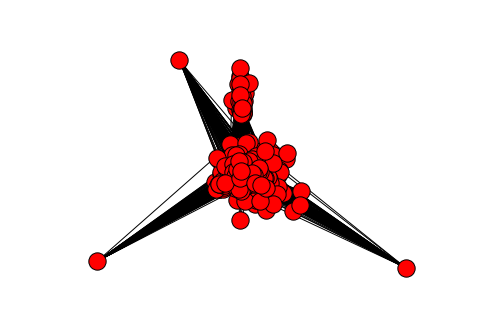

In [84]:
## Cartographie des électeurs similaires
def build_graph(simil, top_users, name="families5_3VFF.gexf"):
    #instancier mon graph non dirigé
    g = nx.Graph()
    labels = {}
    #spatialisation selon l'algo Fruchterman Reingold
    pos = nx.spring_layout(g)
    
    
    for couple, score in simil.items():
        #print(couple)
        g.add_node(couple[1], nb_votes=top_users[couple[1]])
        g.add_node(couple[0], nb_votes=top_users[couple[0]])
        
    g.add_edges_from([(k[0],k[1],{"weight":v}) for k, v in simil.items()])
    
                           
    
        #print(couple)
        #j'ajoute un noeud 
        #qui a pour poids le nombre de votes de l'utilisateur
        #g.add_node(couple[0],label=couple[0] nb_votes=top_users[couple[0]])
        
        #g.add_node(couple[1], nb_votes=top_users[couple[1]])
        #j'ajoute le lien entre les noeuds
        #qui a pour poids le score de similarité
        #g.add_edge(couple[0], couple[1], width=score, edge_color='g')
    
    for node in nx.isolates(g):
        print ("Isolé", node)
        g.remove_node(node)
    name = "graph_similarity_TOP5_SCORE_3_OTHER.gexf"
    nx.write_gexf(g, name)
    nx.draw(g)
    plt.axis('off')
    plt.savefig("family.png") # save as png
    plt.show()
    return
graph = build_graph(similar_couples, electeur_nb_votes)